In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import permutation_importance

In [2]:
# Set a style for the plots
sns.set_style('whitegrid')

### Data Loading and Initial Exploration

In [3]:
print("--- Data Loading ---")
try:
    df = pd.read_csv('diabetes.csv')
    print("Dataset loaded successfully!")
    print("\nInitial Data Head:")
    print(df.head())
    print(f"\nDataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'diabetes.csv' not found. Please download the Pima Indians Diabetes Database and place it in the same directory.")
    exit()

--- Data Loading ---
Dataset loaded successfully!

Initial Data Head:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset shape: (768, 9)


### Data Preprocessing and Feature Engineering

In [4]:
# NEW: Create a new feature combining DiabetesPedigreeFunction and Age
df['Genetics_Age_Interaction'] = df['DiabetesPedigreeFunction'] * df['Age']

In [5]:
# Identify features where 0 represents a missing value
cols_to_replace_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace 0s with NaN values
df[cols_to_replace_zero] = df[cols_to_replace_zero].replace(0, np.nan)

In [6]:
# NEW: Use KNNImputer for more accurate imputation
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [7]:
# Separate features (X) and target (y)
X = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Preprocessing and Normalization Complete.")
print(f"New feature 'Genetics_Age_Interaction' has been added.")

Data Preprocessing and Normalization Complete.
New feature 'Genetics_Age_Interaction' has been added.


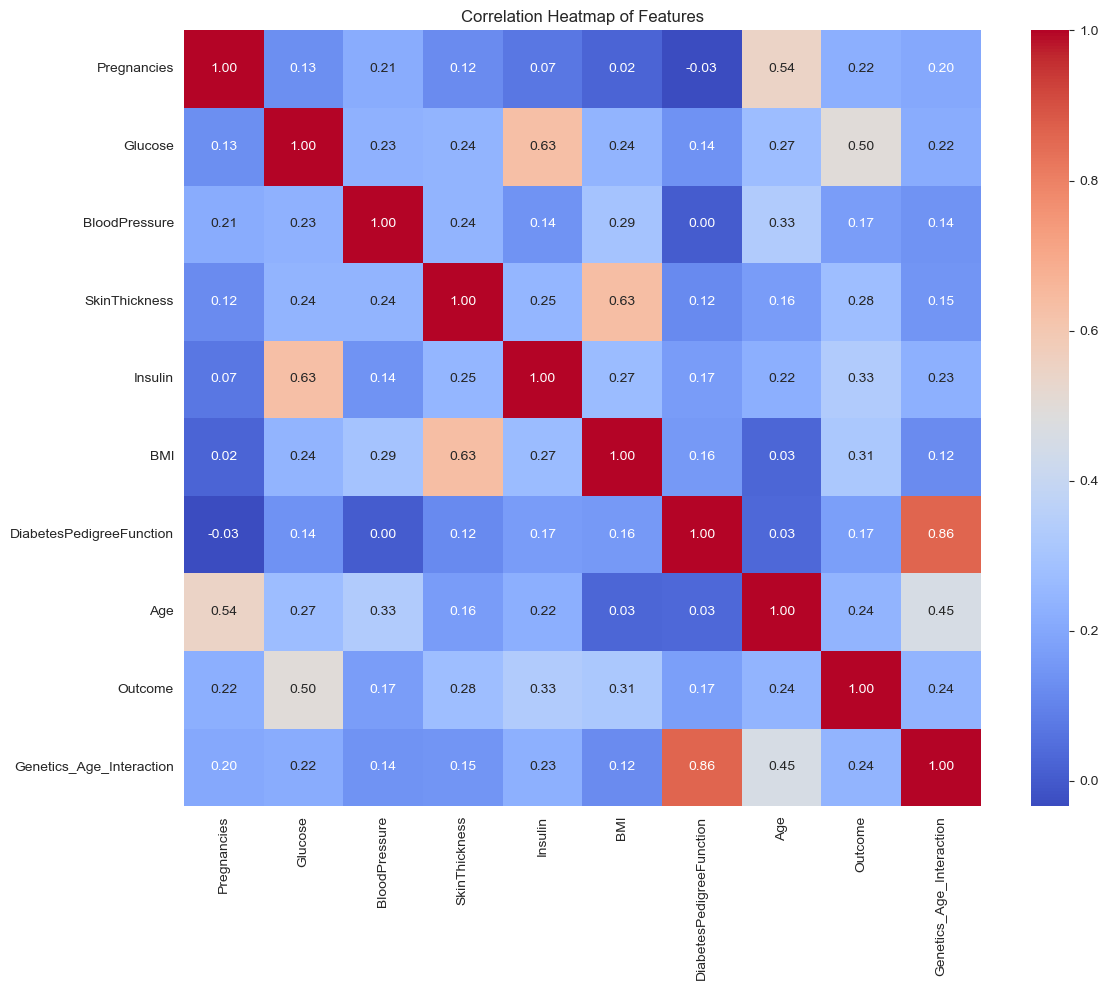

In [10]:
# a) Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

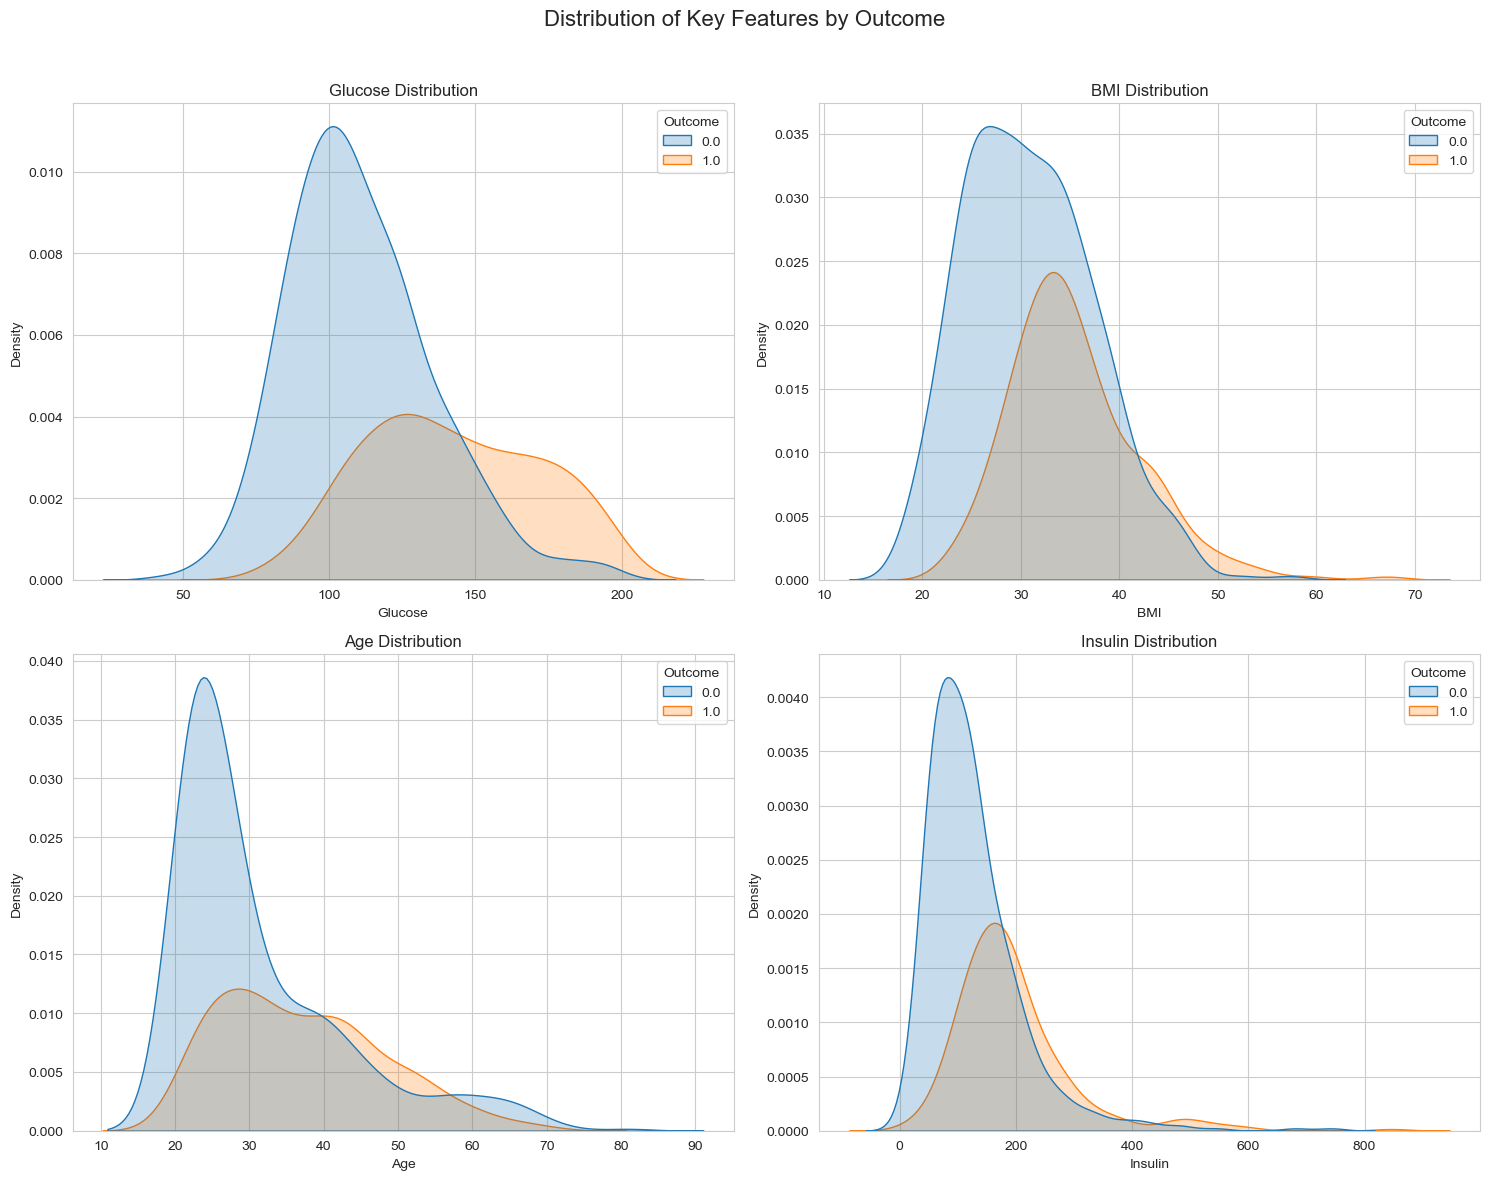

In [11]:
# b) Distribution Plots for key features by Outcome
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
fig.suptitle('Distribution of Key Features by Outcome', fontsize=16)

sns.kdeplot(data=df_imputed, x='Glucose', hue='Outcome', fill=True, ax=axes[0, 0])
axes[0, 0].set_title('Glucose Distribution')

sns.kdeplot(data=df_imputed, x='BMI', hue='Outcome', fill=True, ax=axes[0, 1])
axes[0, 1].set_title('BMI Distribution')

sns.kdeplot(data=df_imputed, x='Age', hue='Outcome', fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution')

sns.kdeplot(data=df_imputed, x='Insulin', hue='Outcome', fill=True, ax=axes[1, 1])
axes[1, 1].set_title('Insulin Distribution')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('feature_distributions.png')
plt.show()

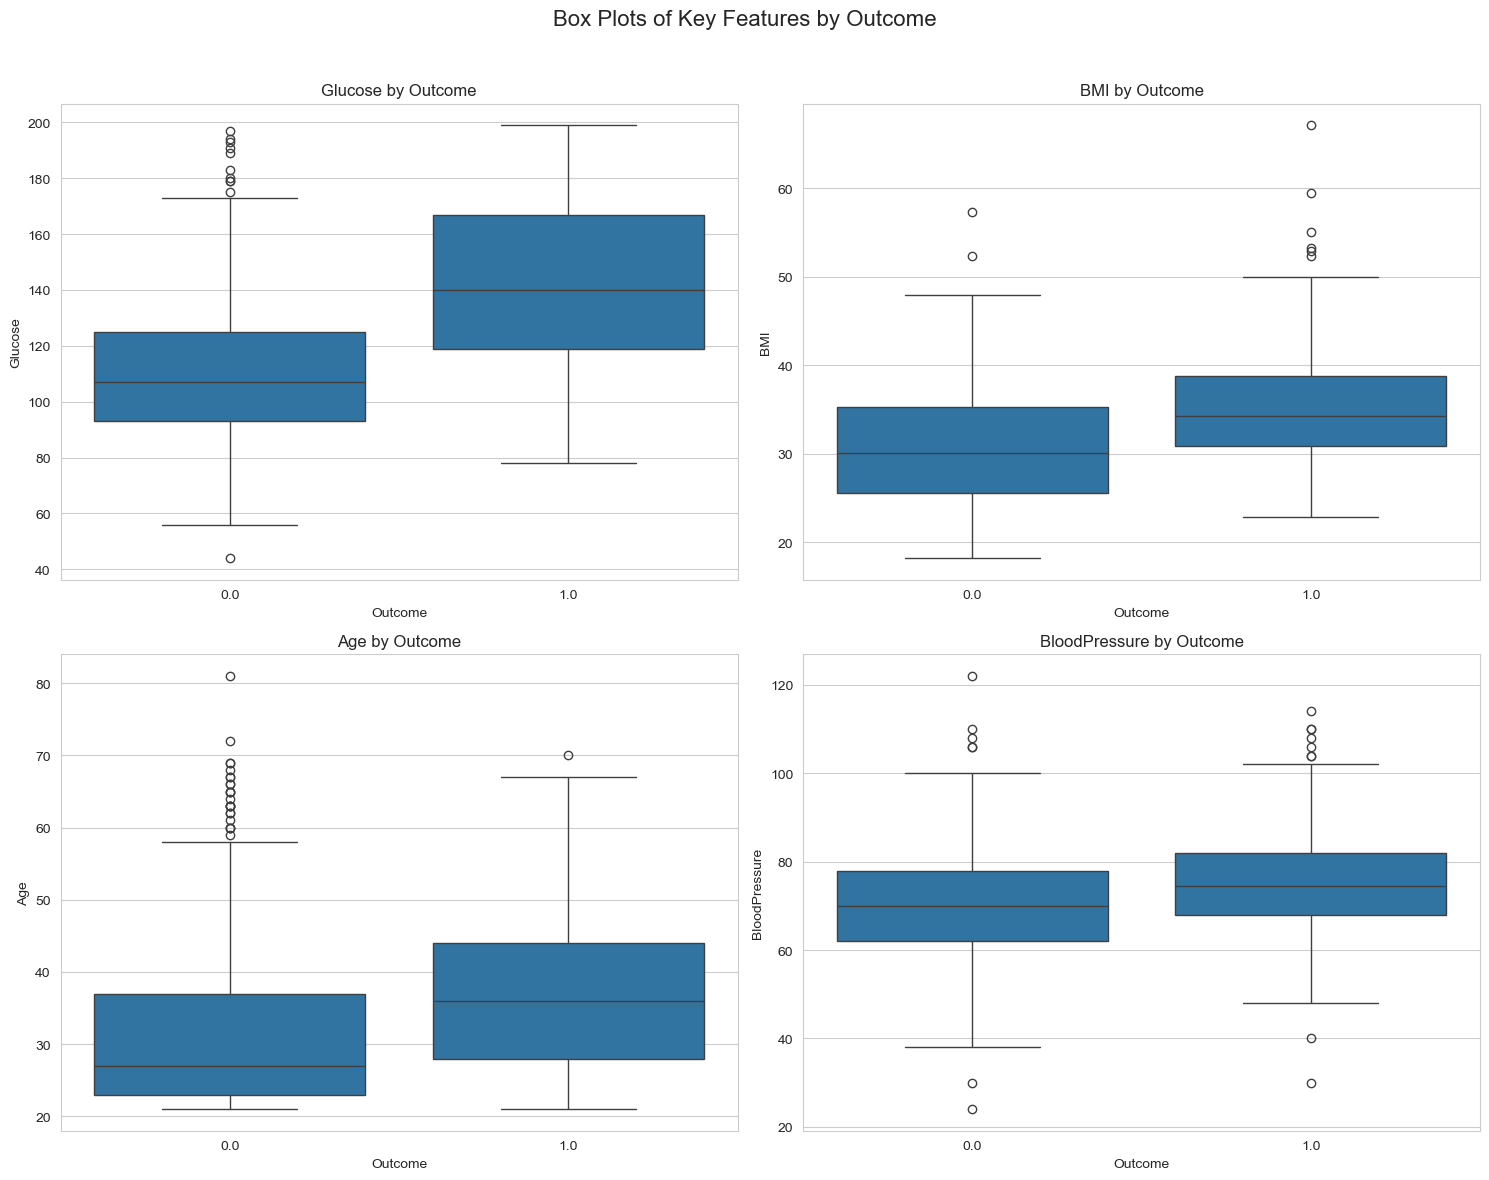

In [12]:
# c) Box Plots for key features by Outcome
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
fig.suptitle('Box Plots of Key Features by Outcome', fontsize=16)

sns.boxplot(data=df_imputed, x='Outcome', y='Glucose', ax=axes[0, 0])
axes[0, 0].set_title('Glucose by Outcome')

sns.boxplot(data=df_imputed, x='Outcome', y='BMI', ax=axes[0, 1])
axes[0, 1].set_title('BMI by Outcome')

sns.boxplot(data=df_imputed, x='Outcome', y='Age', ax=axes[1, 0])
axes[1, 0].set_title('Age by Outcome')

sns.boxplot(data=df_imputed, x='Outcome', y='BloodPressure', ax=axes[1, 1])
axes[1, 1].set_title('BloodPressure by Outcome')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('feature_boxplots.png')
plt.show()

### Model Definition and Cross-Validation

In [13]:
print("\n--- Model Definition & Cross-Validation ---")
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
}
print("Defined Logistic Regression, Random Forest, and Gradient Boosting models.")

for name, model in models.items():
    print(f"\nEvaluating {name} with 5-Fold Cross-Validation...")
    cv_accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_roc_auc = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    print(f"Cross-Validated Accuracy: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std() * 2:.4f})")
    print(f"Cross-Validated ROC AUC: {cv_roc_auc.mean():.4f} (+/- {cv_roc_auc.std() * 2:.4f})")


--- Model Definition & Cross-Validation ---
Defined Logistic Regression, Random Forest, and Gradient Boosting models.

Evaluating Logistic Regression with 5-Fold Cross-Validation...
Cross-Validated Accuracy: 0.7848 (+/- 0.0493)
Cross-Validated ROC AUC: 0.8330 (+/- 0.0354)

Evaluating Random Forest Classifier with 5-Fold Cross-Validation...
Cross-Validated Accuracy: 0.7674 (+/- 0.0323)
Cross-Validated ROC AUC: 0.8213 (+/- 0.0266)

Evaluating Gradient Boosting Classifier with 5-Fold Cross-Validation...
Cross-Validated Accuracy: 0.7570 (+/- 0.0425)
Cross-Validated ROC AUC: 0.8206 (+/- 0.0336)


### Hyperparameter Tuning for Random Forest

In [14]:
print("\n--- Hyperparameter Tuning for Random Forest ---")
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC AUC score from Grid Search: {grid_search_rf.best_score_:.4f}")

# Update the models dictionary with the best Random Forest model
models['Random Forest Classifier (Tuned)'] = grid_search_rf.best_estimator_


--- Hyperparameter Tuning for Random Forest ---
Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best ROC AUC score from Grid Search: 0.8350


### Model Training and Evaluation

In [15]:
print("\n--- Final Model Training and Evaluation on Test Set ---")
results = {}
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)
    
    results[name] = {'accuracy': accuracy, 'roc_auc': roc_auc, 'report': report}
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:\n", report)


--- Final Model Training and Evaluation on Test Set ---

--- Logistic Regression ---
Accuracy: 0.7188
ROC AUC Score: 0.8241
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.82      0.79       125
         1.0       0.61      0.52      0.56        67

    accuracy                           0.72       192
   macro avg       0.69      0.67      0.68       192
weighted avg       0.71      0.72      0.71       192


--- Random Forest Classifier ---
Accuracy: 0.7552
ROC AUC Score: 0.8194
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       125
         1.0       0.67      0.58      0.62        67

    accuracy                           0.76       192
   macro avg       0.73      0.72      0.72       192
weighted avg       0.75      0.76      0.75       192


--- Gradient Boosting Classifier ---
Accuracy: 0.7604
ROC AUC Score: 0.8264
Classification Report:


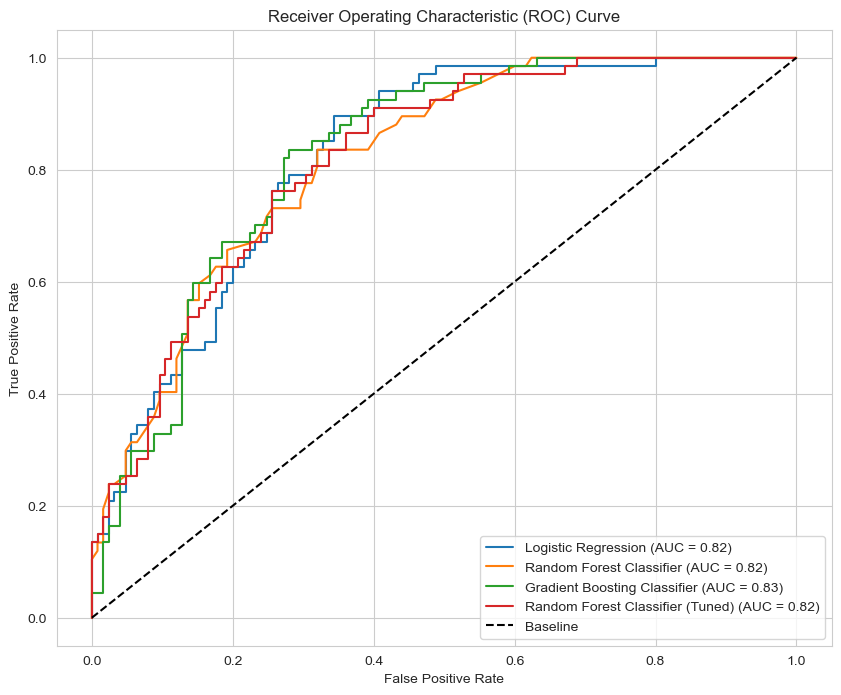

In [16]:
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_val:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve.png')
plt.show()

### Saving the Best Model and Scaler

In [17]:
print("\n--- Saving Final Model and Scaler ---")
best_model_name = max(results, key=lambda name: results[name]['roc_auc'])
best_model = models[best_model_name]
print(f"The best model based on ROC AUC is: {best_model_name}")

joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("The best model and scaler have been saved to 'best_diabetes_model.pkl' and 'scaler.pkl'.")


--- Saving Final Model and Scaler ---
The best model based on ROC AUC is: Gradient Boosting Classifier
The best model and scaler have been saved to 'best_diabetes_model.pkl' and 'scaler.pkl'.
